<a href="https://colab.research.google.com/github/Dirkster99/PyNotes/blob/master/Transformers/LocalModelUsage_Finetuning/63_Transformer_4_Language_Classification_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.2.1

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 2.9MB 17.4MB/s 
     |████████████████████████████████| 890kB 38.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=df8219c838679a11c8ef2a4ed642bd0c3b71bb298affeb8934d4f2b6b32b7697
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Six steps towards building a Language Classification Model with Transformers and TensorFlow 2.0

Original Author: James Briggs
https://www.youtube.com/watch?v=GYDFBfx8Ts8

## Download and Preprocessing Data

### 20 News Groups Categorization Dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
dataPath = '/gdrive/MyDrive/Colab Notebooks/20_Newsgroups TextClassification/data/'
!ls {dataPath.replace(' ', '\ ')}

20news-bydate	      20_newsgroups_data.csv		   model
20news-bydate.tar.gz  20_newsgroups_data_no_filenames.csv


In [3]:
import pandas as pd
df = pd.read_csv(dataPath + '20_newsgroups_data_no_filenames.csv', sep='|')
df.head()

,category,news
0,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...
4,comp.sys.mac.hardware,From: taihou@chromium.iss.nus.sg (Tng Tai Hou)...


In [4]:
# Generate number representation for category field
df['label'] = pd.Categorical(df.category, ordered=True).codes
df['label'].unique()

array([ 9,  4, 11,  0,  5, 13, 12, 17, 10,  6,  7,  2,  8, 14,  1,  3, 16,
       18, 19, 15], dtype=int8)

In [5]:
# Map labels to humand readable category inside a dictionary
mapLabels = pd.DataFrame(df.groupby(['category', 'label']).count())

#drop count column
mapLabels.drop(['news'], axis = 1, inplace = True)
label2Index = mapLabels.to_dict(orient='index')

print (f"label2Index :{label2Index}")
print (type(label2Index))
#print (f"index2Label :{index2Label}")

label2Index :{('alt.atheism', 0): {}, ('comp.graphics', 1): {}, ('comp.os.ms-windows.misc', 2): {}, ('comp.sys.ibm.pc.hardware', 3): {}, ('comp.sys.mac.hardware', 4): {}, ('comp.windows.x', 5): {}, ('misc.forsale', 6): {}, ('rec.autos', 7): {}, ('rec.motorcycles', 8): {}, ('rec.sport.baseball', 9): {}, ('rec.sport.hockey', 10): {}, ('sci.crypt', 11): {}, ('sci.electronics', 12): {}, ('sci.med', 13): {}, ('sci.space', 14): {}, ('soc.religion.christian', 15): {}, ('talk.politics.guns', 16): {}, ('talk.politics.mideast', 17): {}, ('talk.politics.misc', 18): {}, ('talk.religion.misc', 19): {}}
<class 'dict'>


In [6]:
# generate inverse dictionary to map in both directions
index2label = {}

for key in label2Index:
  print (f"{key[1]} -> {key[0]}")
  index2label[key[1]] = key[0]

0 -> alt.atheism
1 -> comp.graphics
2 -> comp.os.ms-windows.misc
3 -> comp.sys.ibm.pc.hardware
4 -> comp.sys.mac.hardware
5 -> comp.windows.x
6 -> misc.forsale
7 -> rec.autos
8 -> rec.motorcycles
9 -> rec.sport.baseball
10 -> rec.sport.hockey
11 -> sci.crypt
12 -> sci.electronics
13 -> sci.med
14 -> sci.space
15 -> soc.religion.christian
16 -> talk.politics.guns
17 -> talk.politics.mideast
18 -> talk.politics.misc
19 -> talk.religion.misc


In [7]:
label2Index = {v: k for k, v in index2label.items()}

print (f'label2Index: {label2Index}')
print (f'index2label: {index2label}')

label2Index: {'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
index2label: {0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os.ms-windows.misc', 3: 'comp.sys.ibm.pc.hardware', 4: 'comp.sys.mac.hardware', 5: 'comp.windows.x', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport.baseball', 10: 'rec.sport.hockey', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion.christian', 16: 'talk.politics.guns', 17: 'talk.politics.mideast', 18: 'talk.politics.misc', 19: 'talk.religion.misc'}


In [8]:
# Remoe Email address to avoid additional noise
df.news.replace(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '', regex=True, inplace=True)

In [9]:
df.rename(columns = {'label' : 'labels', 'news' : 'text'}, inplace = True)

In [10]:
df = df[['text','labels']]

In [11]:
df.head()

,text,labels
0,From: ( )\nSubj...,9
1,From: (Gregory Nelson)\nSubject: Thanks Apple...,4
2,From: \nSubject: Cryptography FAQ 10/10 - Refe...,11
3,From: (Keith Allan Schneider)\nSubject: Re: <...,0
4,From: (Tng Tai Hou)\nSubject: ADB and graphic...,4


In [12]:
# Drop duplicates to avoid pulliting the test data set with previously seen training data
# when doing a simple test/train split on 1 file instead of using 2 files
# df.drop_duplicates(subset='text', keep='first', inplace=True)

In [13]:
df.count()

text      11270
labels    11270
dtype: int64

In [14]:
print (f"There are {df['labels'].nunique()} unique values {df['labels'].unique()} in the 'labels' column.")

There are 20 unique values [ 9  4 11  0  5 13 12 17 10  6  7  2  8 14  1  3 16 18 19 15] in the 'labels' column.


### One Hot Encode a continues label value (eg. 0-4)

In [15]:
arr = df['labels'].values
arr.size

11270

In [16]:
arr.max()

19

In [17]:
import numpy as np
labels = np.zeros((arr.size, arr.max() + 1), dtype=int)
labels.shape

(11270, 20)

In [18]:
labels[np.arange(arr.size), arr] = 1
labels.shape

(11270, 20)

In [19]:
for i in range(0, 20):
  print(labels[i])

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Encode Text Input Data

In [20]:
seqlen = df['text'].apply(lambda x: len(x.split()))

In [21]:
import seaborn as sns
import matplotlib as plt

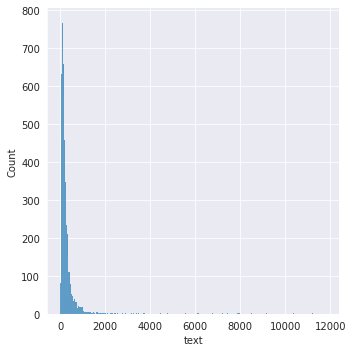

In [22]:
# Do a distribution plot on the seqquence length's of the given text
sns.set_style('darkgrid')
plt.figure.Figure(figsize=(16,10))
sns.displot(seqlen)

In [23]:
# Maximum length of the text we are going to train and predict here
SEQ_LEN = 300

## Encode Input Data
Encode the Input-Tensor and the Attention Tensor.

In [24]:
from transformers import AutoTokenizer
tranformersPreTrainedModelName = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tranformersPreTrainedModelName) 

In [25]:
tokens = tokenizer.encode_plus('Hello World'
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')

In [26]:
# Outputs 2 tensors named 'input_ids' & 'attention_mask'
# The values 101 and 102 are start and end of sentence identifiers
# while 7592 & 2088 are tokens for 'Hello World'
#
# Attention Mask tells Bert which tokens to pay attention to and which to ompletely ignore
print (tokens)

{'input_ids': <tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[ 101, 7592, 2088,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

### Tokenize each Sample in Dataset

In [27]:
import numpy as np
# initialize numpy arrays for Token-Ids and Attention Masks
Xids = np.zeros((len(df), SEQ_LEN), dtype=int)
Xmask = np.zeros((len(df), SEQ_LEN), dtype=int)

In [28]:
Xids.shape

(11270, 300)

In [29]:
# Use a simple for loop to encode all data points
for i, sequence in enumerate(df['text']):
  tokens = tokenizer.encode_plus(sequence
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')
  
  Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [30]:
# Array of tokenized Ids
Xids

array([[ 101, 2013, 1024, ...,    0,    0,    0],
       [ 101, 2013, 1024, ..., 2151, 1997,  102],
       [ 101, 2013, 1024, ..., 1998, 4556,  102],
       ...,
       [ 101, 2013, 1024, ..., 1011, 1011,  102],
       [ 101, 2013, 1024, ..., 1037, 2261,  102],
       [ 101, 2013, 1024, ...,    0,    0,    0]])

In [31]:
# Array of attaention masks
Xmask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])

### Save Tokenized Data

In [32]:
with open ('xids.npy', 'wb') as f:
  np.save(f, Xids)
with open ('xmask.npy', 'wb') as f:
  np.save(f, Xmask)
with open ('labels.npy', 'wb') as f:
  np.save(f, labels)

del df, Xids, Xmask, labels
df = None

## Ininitializing Hugging Face Tokenizer and Model

### Load Tokenized Data

In [33]:
import numpy as np
with open ('xids.npy', 'rb') as f:
  Xids = np.load(f)
with open ('xmask.npy', 'rb') as f:
  Xmask = np.load(f)
with open ('labels.npy', 'rb') as f:
  labels = np.load(f)

In [34]:
Xids

array([[ 101, 2013, 1024, ...,    0,    0,    0],
       [ 101, 2013, 1024, ..., 2151, 1997,  102],
       [ 101, 2013, 1024, ..., 1998, 4556,  102],
       ...,
       [ 101, 2013, 1024, ..., 1011, 1011,  102],
       [ 101, 2013, 1024, ..., 1037, 2261,  102],
       [ 101, 2013, 1024, ...,    0,    0,    0]])

In [35]:
for i in range(0, 20):
  print(labels[i])

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
import tensorflow as tf
#tf.config.list_physical_device('GPU')

In [37]:
# TensorFlow expects input and target labels as an input tuple
# Bert expects a dictionary of 'input_ids' and 'attention_mask' as input
# So, lets create the dataset object
# This creates a generator for a tuple of input tokens, attention_masks, and target labels
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [38]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ((300,), (300,), (20,)), types: (tf.int64, tf.int64, tf.int64)>

(<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([  101,  2013,  1024,  1006,  1007,  3395,  1024,  2128,  1024,
       12469,  2369, 27055,  1029,  2129,  1029,  3720,  1011,  1045,
        1012,  1040,  1012,  1024, 12943,  3686,  1012,  1015, 13876,
       28154,  2475,  1002,  1042,  2683,  2050,  3029,  1024,  2118,
        1997,  2662,  1010,  8256,  3210,  1024,  2260,  1050,  3372,
        2361,  1011, 14739,  1011,  3677,  1024, 11721, 26573,  1012,
        8256,  1012,  3968,  2226,  7009,  1024,  5253,  1998, 22789,
        2097,  2031,  3690,  1005,  1055,  1015,  2448,  3020,  2084,
        2197,  2095,  1010,  1998,  1996, 12469,  2097,  2022, 28781,
        1998,  2025,  6510,  5292, 25074,  2100,  2004,  2172,  2004,
        7632, 22414,  4103,  1012, 19371,  2180,  1005,  1056,  2022,
        2204,  1006,  1045,  2228,  2002,  1005,  1055,  1037, 16054,
        8070,  1007,  2023,

In [39]:
# minute 21:55
# TensorFlow Bert model expects our input in a Tuple format containing:
# 1) 'input_ids' and 'attention_mask' in a Dictionary and
# 2) a label as 2nd part of the tupel
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [40]:
# we can use the dataset map function to apply this format
dataset = dataset.map(map_func)

In [41]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ({input_ids: (300,), attention_mask: (300,)}, (20,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

({'input_ids': <tf.Tensor: shape=(300,), dtype=int64, numpy=
array([  101,  2013,  1024,  1006,  1007,  3395,  1024,  2128,  1024,
       12469,  2369, 27055,  1029,  2129,  1029,  3720,  1011,  1045,
        1012,  1040,  1012,  1024, 12943,  3686,  1012,  1015, 13876,
       28154,  2475,  1002,  1042,  2683,  2050,  3029,  1024,  2118,
        1997,  2662,  1010,  8256,  3210,  1024,  2260,  1050,  3372,
        2361,  1011, 14739,  1011,  3677,  1024, 11721, 26573,  1012,
        8256,  1012,  3968,  2226,  7009,  1024,  5253,  1998, 22789,
        2097,  2031,  3690,  1005,  1055,  1015,  2448,  3020,  2084,
        2197,  2095,  1010,  1998,  1996, 12469,  2097,  2022, 28781,
        1998,  2025,  6510,  5292, 25074,  2100,  2004,  2172,  2004,
        7632, 22414,  4103,  1012, 19371,  2180,  1005,  1056,  2022,
        2204,  1006,  104

In [42]:
# SHuffle and Bach Dataset
dataset = dataset.shuffle(1000).batch(32)

In [43]:
# Get the total size of dataset now that it is batched
#
# the dataset object is a generator object so we cannot take the length of it directly
# thus, we have to convert it into a list
# 
# Do not do this with a very large dataset
#
DS_LEN = len(list(dataset))
DS_LEN

353

In [44]:
print (f"Alternative Computation for DS_LEN: {len(Xids)/32} -> {round(len(Xids)/32, 0)}")

Alternative Computation for DS_LEN: 352.1875 -> 352.0


In [45]:
SPLIT = .9

# take or skip the specified number of batches to split by factor
train = dataset.take(round(DS_LEN * SPLIT))
evalu = dataset.skip(round(DS_LEN * SPLIT))

del dataset

## Build Model

In [53]:
from transformers import BertConfig
bertConfig = BertConfig.from_pretrained(tranformersPreTrainedModelName
                                        , output_hidden_states=True
                                        , num_lables=6
                                        , max_length=SEQ_LEN)

In [54]:
from transformers import TFBertForSequenceClassification
tranformersPreTrainedModelName = 'bert-base-uncased'
bert = TFBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config=bertConfig)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
bert.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [56]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
bert.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
    )

In [57]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()

history = bert.fit(train, validation_data=evalu, epochs=6)

end = timer()
print(timedelta(seconds=end-start))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/6


ValueError: ignored